In [37]:
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit
import sympy as sp
import matplotlib.pyplot as plt

from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

from qiskit_algorithms.optimizers import SPSA
from scipy.optimize import minimize

from tqdm import tqdm


plt.rcParams['text.usetex'] = True


%matplotlib widget

## Part A

In [38]:

def numpy_to_sympy(arr, constants=[sp.sqrt(2)]):
    """
    Convert a NumPy array to a Sympy Matrix with each element simplified.
    
    Parameters:
      arr (np.array): The NumPy array to convert.
      constants (list): Constants to use for nsimplify (default includes sqrt(2)).
    
    Returns:
      sp.Matrix: A symbolic matrix with simplified elements.
    """

    arr = np.array(arr)  # Ensure it's a NumPy array
    if arr.ndim == 1:
        return sp.Matrix([sp.nsimplify(x, constants) for x in arr])
    elif arr.ndim >1:
        return sp.Matrix([[sp.nsimplify(x, constants) for x in row] for row in arr])
    else:
        # For higher dimensions, you might want to extend this approach.
        raise ValueError("Array with ndim > 2 is not supported.")
    
# Define Pauli Matrices (X, Y, Z), Hadamard gate (H), Phase gate (S)
state0 = np.array([1, 0])
state1 = np.array([0, 1])
state00 = np.kron(state0, state0)
state01 = np.kron(state0, state1)
state10 = np.kron(state1, state0)
state11 = np.kron(state1, state1)

X = np.array([[0, 1],
                [1, 0]])
Y = np.array([[0, -1j],
                [1j, 0]])
Z = np.array([[1, 0],
                [0, -1]])
H = (1/np.sqrt(2)) * np.array([[1,  1],
                                [1, -1]])
S = np.array([[1, 0],
                [0, 1j]])
I = np.array([[1,0],
              [0,1]])
# One qubit
basis_states = {'|0>': state0, '|1>': state1, '|00>':state00, '|01>':state01, '|10>':state10, '|11>':state11}
gates = {'X': X, 'Y': Y, 'Z': Z, 'H': H, 'S': S}

# Apply each gate to each basis state and print the result
for label, state in  list(basis_states.items())[:2]:
    print(f"State {label}: {state}")
    for gate_name, gate in gates.items():
        result = np.dot(gate, state)
        # Convert the array to a string that represents a list of lists.
        sym_result = numpy_to_sympy(result)
        print(f"  Applying {gate_name} gate to {label}")
        sp.pprint(sym_result)
    print("\n")


# 2 qubits system
# Define Bell States
phi_plus = 1/np.sqrt(2) * (state00 + state11)
phi_minus = 1/np.sqrt(2) * (state00 - state11)

psi_plus = 1/np.sqrt(2) * (state01 + state10)
psi_minus = 1/np.sqrt(2) * (state01 - state10)

# Apply Hadamard gate only to first bit qubit of phi_plus and then CNOT gate
CNOT = np.zeros((4,4))
CNOT[0,0] = 1; CNOT[1,1] = 1; CNOT[2,3] = 1; CNOT[3,2] = 1
new_state = CNOT @ np.kron(H, I) @ psi_plus
new_state_sp = numpy_to_sympy(new_state)
print(sp.pretty_print(new_state_sp))

State |0>: [1 0]
  Applying X gate to |0>
⎡0⎤
⎢ ⎥
⎣1⎦
  Applying Y gate to |0>
⎡0⎤
⎢ ⎥
⎣ⅈ⎦
  Applying Z gate to |0>
⎡1⎤
⎢ ⎥
⎣0⎦
  Applying H gate to |0>
⎡√2⎤
⎢──⎥
⎢2 ⎥
⎢  ⎥
⎢√2⎥
⎢──⎥
⎣2 ⎦
  Applying S gate to |0>
⎡1⎤
⎢ ⎥
⎣0⎦


State |1>: [0 1]
  Applying X gate to |1>
⎡1⎤
⎢ ⎥
⎣0⎦
  Applying Y gate to |1>
⎡-ⅈ⎤
⎢  ⎥
⎣0 ⎦
  Applying Z gate to |1>
⎡0 ⎤
⎢  ⎥
⎣-1⎦
  Applying H gate to |1>
⎡ √2 ⎤
⎢ ── ⎥
⎢ 2  ⎥
⎢    ⎥
⎢-√2 ⎥
⎢────⎥
⎣ 2  ⎦
  Applying S gate to |1>
⎡0⎤
⎢ ⎥
⎣ⅈ⎦


⎡1/2 ⎤
⎢    ⎥
⎢1/2 ⎥
⎢    ⎥
⎢1/2 ⎥
⎢    ⎥
⎣-1/2⎦
None


In [39]:
# Measurement
# Define helper function for the Kronecker power.
def matrix_kron_power(A, n):
    """Return the n–fold Kronecker product of matrix A with itself."""
    if n < 1:
        return np.array([1])
    result = A
    for i in range(1, n):
        result = np.kron(result, A)
    return result

def measure(psi, idx=0, tostate=0, collapse=True):
    
    # Determine the number of qubits.
    n = int(np.log2(len(psi)))

    # Density matrix
    rho = np.outer(psi, psi.conj())

    # Define projectors
    if tostate == 0:
        op = np.outer(state0,state0)
    else:
        op = np.outer(state1, state1)

    # Augment the projector
    if idx > 0:
        op = np.kron(matrix_kron_power(np.eye(2), idx), op)
    if idx < n - 1:
        op = np.kron(op, matrix_kron_power(np.eye(2), n - idx - 1))

    prob0 = np.trace(np.matmul(op, rho))
    if collapse:
        mvul = np.dot(op, psi)
        divisor = np.real(np.linalg.norm(mvul))
        if divisor > 1e-10:
            normed = mvul/divisor
        else:
            raise AssertionError(
                "Measure collapsed to 0.0 probability state"
            )
        return np.real(prob0), normed

    return np.real(prob0), psi

states = {"00":0, "01":0, "10":0, "11":0}

nshots = 10000
for shot in range(nshots):
    # First we measure the first qubit and we get the probability that the first qubit is |0>
    probability_qubit1_0, _ = measure(new_state, idx=0, tostate=0, collapse=True)
    # Measure the first quibit and we get the probability that the first qubit is |1>
    probability_qubit1_1, _ = measure(new_state, idx=0, tostate=1, collapse=True)

    state_qubit1 = np.random.binomial( 1, probability_qubit1_0)

    # We measure qubit 1 and the new state is
    _, state_after_measuring_q1 = measure(new_state, idx=0, tostate=state_qubit1, collapse=True)

    # Now we measure qubit 2
    probability_qubit2_0, _ = measure(state_after_measuring_q1, idx=1, tostate=0, collapse=True)
    # Measure the first quibit and we get the probability that the first qubit is |1>
    probability_qubit2_1, _ = measure(state_after_measuring_q1, idx=1, tostate=1, collapse=True)

    state_qubit2 = np.random.binomial(1, probability_qubit2_0)

    final_state = measure(state_after_measuring_q1, idx=1, tostate=state_qubit2, collapse=True)

    states[str(state_qubit1)+str(state_qubit2)] +=1

print(states)
for key, value in states.items():
    print(key, round(value/nshots*100))


{'00': 2423, '01': 2543, '10': 2511, '11': 2523}
00 24
01 25
10 25
11 25


=== Bell State Preparation and Measurement ===

Bell state measurement results (counts):
{'11': 2478, '01': 2500, '00': 2472, '10': 2550}


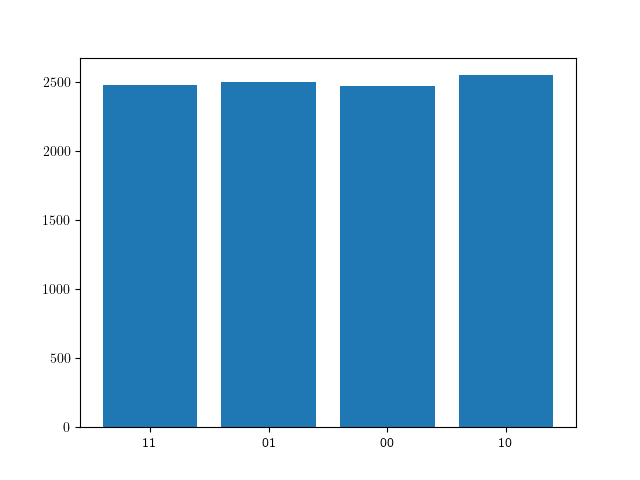

In [40]:
def simulate_bell_state(shots=1024):
    # Create a quantum circuit with 2 qubits and 2 classical bits
    qc = QuantumCircuit(2, 2)
    
    # Prepare Bell state |Φ+> = (|00> + |11>)/sqrt(2)
    qc.h(0)     # Apply Hadamard on qubit 0
    qc.cx(0, 1) # Apply CNOT with qubit 0 as control and qubit 1 as target
    
    # Apply Hadamard and 
    qc.h(0)
    qc.cx(0,1)
    # Measure both qubits
    qc.measure(0, 0)  # Measure qubit 0 into classical bit 0
    qc.measure(1, 1)  # Measure qubit 1 into classical bit 1
    
    # Execute the circuit on the qasm simulator
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(qc, backend=simulator, shots=shots).result()
    counts = result.get_counts(qc)
    
    plt.figure()
    print("Bell state measurement results (counts):")
    print(counts)
    plt.bar(counts.keys(), counts.values())
    # Compute average (expectation value) for each qubit:
    # For each outcome (e.g., '01'), outcome[0] is qubit 0 and outcome[1] is qubit 1.


print("=== Bell State Preparation and Measurement ===\n")
simulate_bell_state(shots=10000)


## Part B

In [41]:
E1 = 0
E2 = 4
V11 = 3
V22 = -3
V12 = 0.2
V21 = 0.2
H_0 = np.array([[E1, 0],[0,E2]])
H_I = np.array(([[V11, V12],[V21, V22]]))

H = H_0 + H_I
H_0_sp = numpy_to_sympy(H_0)
H_I_sp = numpy_to_sympy(H_I)
H_sp = numpy_to_sympy(H)

sp.pretty_print(H_0_sp)
sp.pretty_print(H_I_sp)
sp.pretty_print(H_sp)

⎡0  0⎤
⎢    ⎥
⎣0  4⎦
⎡ 3   1/5⎤
⎢        ⎥
⎣1/5  -3 ⎦
⎡ 3   1/5⎤
⎢        ⎥
⎣1/5   1 ⎦


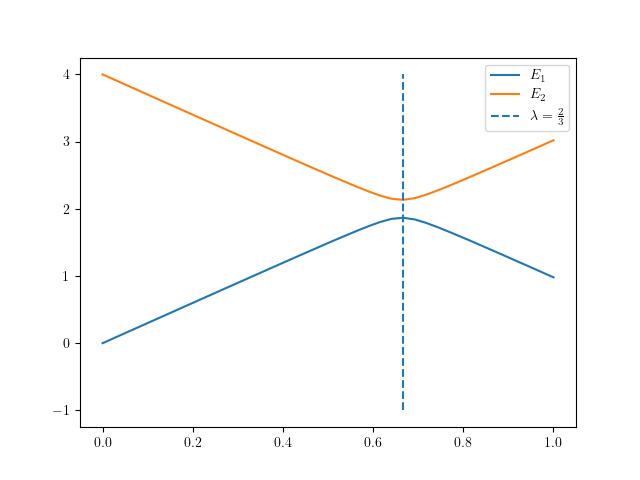

In [42]:
import matplotlib.pyplot as plt
# We can weight the interaction matrix with a parameter \lambda
#number of lambda values
n = 40
lmbdas = np.linspace(0.0,1.0,n)
Eigenvalue = np.zeros((2,n))
Eigvector = [np.zeros((2,2)).copy() for _ in range(n)]

for i in range(n):
    lmbda = lmbdas[i]
    H = H_0 + lmbda * H_I
    eigenvalues, eigenvectors = np.linalg.eig(H)
    permute = eigenvalues.argsort()
    eigenvalues = eigenvalues[permute]
    eigenvectors = eigenvectors[:,permute]
    Eigenvalue[0,i] = eigenvalues[0]
    Eigenvalue[1,i] = eigenvalues[1]
    Eigvector[i][:,0] = eigenvectors[0]
    Eigvector[i][:,1] = eigenvectors[1]
    
plt.figure()
plt.plot(lmbdas, Eigenvalue[0,:], label=r"$E_1$")
plt.plot(lmbdas, Eigenvalue[1,:], label=r"$E_2$")
plt.vlines(x=2/3, ymin=-1, ymax=4, linestyles="--", label=r"$\lambda=\frac{2}{3}$")
plt.legend()


In [43]:
# component_0 = []
# component_1 = []
# for i,lmbda in enumerate(lmbdas):
#     c0 = np.outer(state0, state0) @ Eigvector[i][:,0]
#     c1 = np.outer(state1, state1) @ Eigvector[i][:,0]
#     component_0 +=[abs(c0[0])**2]
#     component_1 +=[abs(c1[1])**2]

# plt.figure()
# plt.plot(lmbdas, component_0)
# plt.plot(lmbdas, component_1)
# plt.vlines(x=2/3, ymin=0, ymax=1, linestyles="--")

## Part C

In [44]:
# Code from FYS-5419 course. Author: Morten Hjorth-Jensen

from qc import *

def prepare_state(theta, phi, target = None):
    I = np.eye(2)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    state = np.array([1, 0])
    Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * sigma_x
    Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * sigma_y
    state = Ry @ Rx @ state
    if target is not None:
        state = target
    return state

def get_energy(angles, lmb, number_shots, target = None):
    theta, phi = angles[0], angles[1]
    # print(f'Theta = {theta}, Phi = {phi}')
    E1 = 0; E2 = 4; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2

    eps = (E1 + E2) / 2; omega = (E1 - E2) / 2; c = (V11 + V22) / 2; omega_z = (V11 - V22) / 2; omega_x = V12

    init_state = prepare_state(theta, phi, target)
    qubit = One_qubit()
    qubit.set_state(init_state)
    measure_z = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_hadamard()
    measure_x = qubit.measure(number_shots)
    
    # expected value of Z = (number of 0 measurements - number of 1 measurements)/ number of shots
    # number of 1 measurements = sum(measure_z)
    exp_val_z = (omega + lmb*omega_z)*(number_shots - 2*np.sum(measure_z)) / number_shots
    exp_val_x = lmb*omega_x*(number_shots - 2*np.sum(measure_x)) / number_shots
    exp_val_i = (eps + c*lmb) 
    exp_val = (exp_val_z + exp_val_x + exp_val_i)
    return exp_val 

In [45]:
number_shots = 10_000
lmbvalues_scipy = np.linspace(0.0, 1.0, 50)
min_energy_scipy = np.zeros(len(lmbvalues_scipy))
for index, lmb in enumerate(tqdm(lmbvalues_scipy)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


In [46]:
# Express Hamiltonian as function of Pauli matrix and compute VQE
# Code taken from IBM Variational quantum eigensolver
epsilon = (E1 + E2)/2
omega = (E1 - E2)/2
c = (V11 + V22)/2
omegaz = (V11 - V22)/2
omegax = V12

In [47]:
# Inspired by this: https://github.com/qiskit-community/qiskit-algorithms/blob/stable/0.3/docs/tutorials/01_algorithms_introduction.ipynb
num_qubits = 1
ansatz = TwoLocal(num_qubits, rotation_blocks=["rx", "ry"], reps=0)
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
minimum_eigenvalues = []
for lmbda in np.linspace(0,1,10):

    hamiltonian = SparsePauliOp.from_list(
        [("I", epsilon + lmbda*c), ("Z", omega + lmbda*omegaz), ("X", lmbda*omegax)]
    )

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    minimum_eigenvalues += [result.eigenvalue]
    



/tmp/ipykernel_160567/576641091.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})


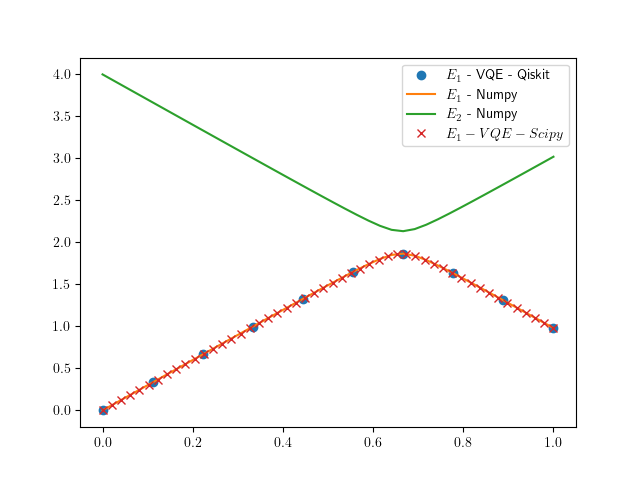

In [48]:
plt.figure()
plt.plot(np.linspace(0,1,10), minimum_eigenvalues, linestyle="", marker="o", label=r"$E_1$ - VQE - Qiskit")
plt.plot(lmbdas, Eigenvalue[0,:], label=r"$E_1$ - Numpy")
plt.plot(lmbdas, Eigenvalue[1,:], label=r"$E_2$ - Numpy")
plt.plot(lmbvalues_scipy, min_energy_scipy, marker="x", linestyle="", label = r'$E_1 - VQE - Scipy$')
plt.legend()


## Part D

We consider a 2 quibits system.

In [49]:
# We extend the Hamiltonian to a 2 qubits system

eps00 = 0.0
eps10 = 2.5
eps01 = 6.5
eps11 = 7.0
Hx = 2.0 
Hz = 3.0

lmbda = 1
H_0 = np.array([[eps00, 0, 0,0],[0, eps10, 0, 0],[0, 0, eps01, 0],[0, 0, 0, eps11]])
H_I = Hz*np.kron(Z, Z) + Hx*np.kron(X, X)

H = H_0 + lmbda*H_I
H_sp = numpy_to_sympy(H)
sp.pretty_print(H_sp)


⎡3   0     0   2 ⎤
⎢                ⎥
⎢0  -1/2   2   0 ⎥
⎢                ⎥
⎢0   2    7/2  0 ⎥
⎢                ⎥
⎣2   0     0   10⎦


In [50]:
print(H)

[[ 3.   0.   0.   2. ]
 [ 0.  -0.5  2.   0. ]
 [ 0.   2.   3.5  0. ]
 [ 2.   0.   0.  10. ]]


In [51]:
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])

sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])
I = np.eye(2)

def Hamiltonian(lmb):    
    Hx = 2.0 
    Hz = 3.0
    H0Energiesnoninteracting = [0.0, 2.5, 6.5, 7.0]
    
    HI = Hz*np.kron(sigma_z, sigma_z) + Hx*np.kron(sigma_x, sigma_x)
    H0 = np.diag(H0Energiesnoninteracting)
    H = H0 + lmb*HI
    return H

def trace_out(state, index):
    density = np.outer(state, np.conj(state))
    if index == 0:
        op0 = np.kron(ket0, I)
        op1 = np.kron(ket1, I)
    elif index == 1:
        op0 = np.kron(I, ket0)
        op1 = np.kron(I, ket1)
    return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T # need to take conj() on first and .T on second since np.arrays are 


In [52]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, lmb, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_cnot10() # rotate measurement basis
    measure_zz = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_zz, measure_xx])
    constants = np.array([B, C, D + lmb*Hz, lmb*Hx])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = A + np.sum(constants * exp_vals) / number_shots
    return exp_val


In [53]:
number_shots = 10_000
lmbvalues = np.linspace(0.0, 1.0, 50)
min_energy_scipy = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Compute the eigenvalues utilizing the Numpy library Linalg

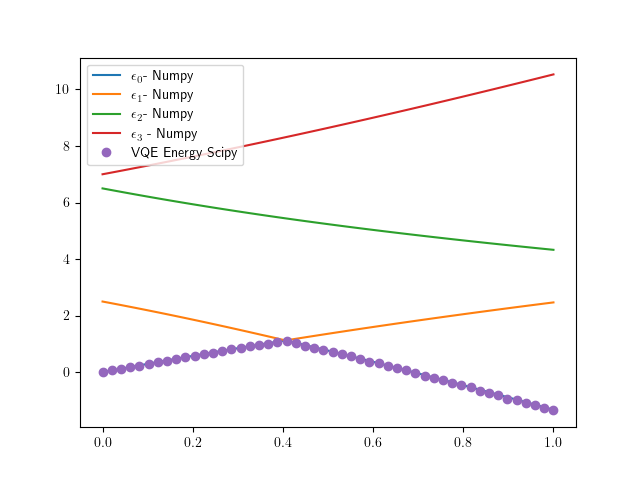

In [54]:
n = 100
lmbdas = np.linspace(0.0,1.0,n)
Eigenvalue = np.zeros((4,n))
Eigvector = [np.zeros((4,4)).copy() for _ in range(n)]
entropy = np.zeros((n, 4))

for i in range(n):
    lmbda = lmbdas[i]
    H = H_0 + lmbda*H_I
    eigenvalues, eigenvectors = np.linalg.eig(H)
    permute = eigenvalues.argsort()
    eigenvalues = eigenvalues[permute]
    eigenvectors = eigenvectors[:,permute]
    Eigenvalue[0,i] = eigenvalues[0]
    Eigenvalue[1,i] = eigenvalues[1]
    Eigenvalue[2,i] = eigenvalues[2]
    Eigenvalue[3,i] = eigenvalues[3]
    Eigvector[i][:,0] = eigenvectors[0]
    Eigvector[i][:,1] = eigenvectors[1]
    Eigvector[i][:,2] = eigenvectors[2]
    Eigvector[i][:,3] = eigenvectors[3]
    for j in range(4):
        sub_density = trace_out(eigenvectors[:, j], 0) # trace out qubit 0 from the ground state
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed() # remove zeros to avoid log(0)
        entropy[i, j] = -np.sum(lmb_density*np.log2(lmb_density))


plt.figure()
plt.plot(lmbdas, Eigenvalue[0,:], label=r'$\epsilon_{0}$- Numpy')
plt.plot(lmbdas, Eigenvalue[1,:], label=r'$\epsilon_{1}$- Numpy')
plt.plot(lmbdas, Eigenvalue[2,:], label=r'$\epsilon_{2}$- Numpy')
plt.plot(lmbdas, Eigenvalue[3,:], label=r'$\epsilon_{3}$ - Numpy')
plt.plot(lmbvalues, min_energy_scipy, label='VQE Energy Scipy', marker='o', linestyle="")
plt.legend()
plt.show()

/tmp/ipykernel_160567/2092346006.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


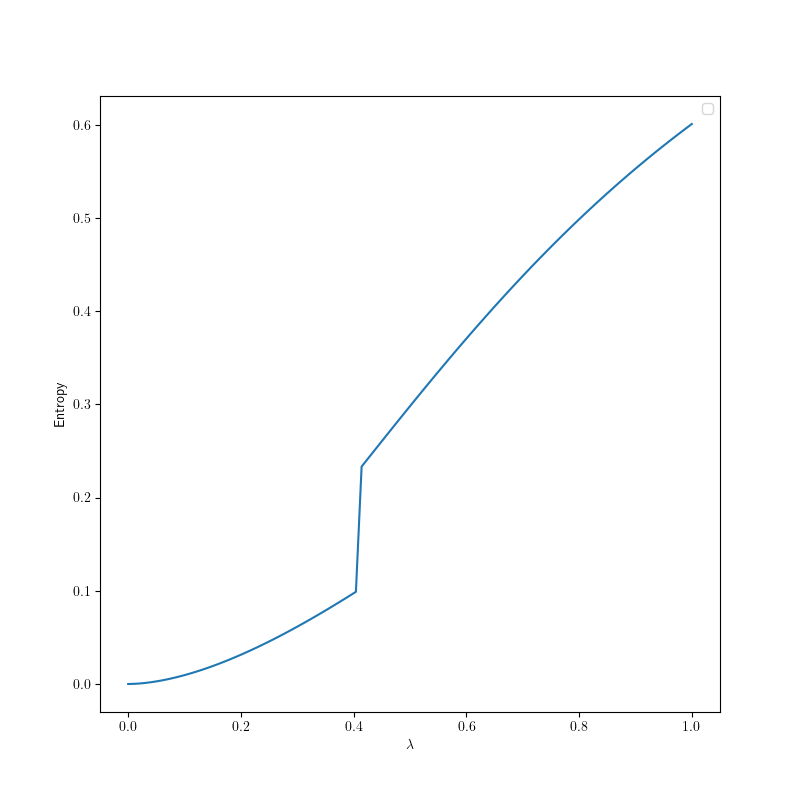

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
for i in range(1):
    axs.plot(lmbdas, entropy[:, i])    
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Entropy')
axs.legend()
plt.show()


## Part E

In [56]:
# We can compute min eigenvalue using quiskit

# Rewrite Hamiltonian as function of Pauli Matrices

A = (eps00 + eps01 + eps10 + eps11) / 4.0 # IxI
B = (eps00 - eps01 + eps10 - eps11) / 4.0 # IxZ
C = (eps00 + eps01 - eps10 - eps11) / 4.0 # ZxI
D = (eps00 - eps01 - eps10 + eps11) / 4.0 # ZxZ

# Generate ansatz for 2 qubit system


In [57]:
# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
from qiskit_algorithms.utils import algorithm_globals

minimum_eigenvalues_2q = []
for i, lmbda in enumerate(tqdm(np.linspace(0,1,20))):
    hamiltonian_2qb= SparsePauliOp.from_list(
        [("II", A), ("IZ", B), ("ZI", C), ("ZZ", lmbda*Hz+D), ("XX", lmbda*Hx)]
    )
    ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cx")
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_2qb)
    minimum_eigenvalues_2q +=[result.eigenvalue.real]


/tmp/ipykernel_160567/4017680609.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


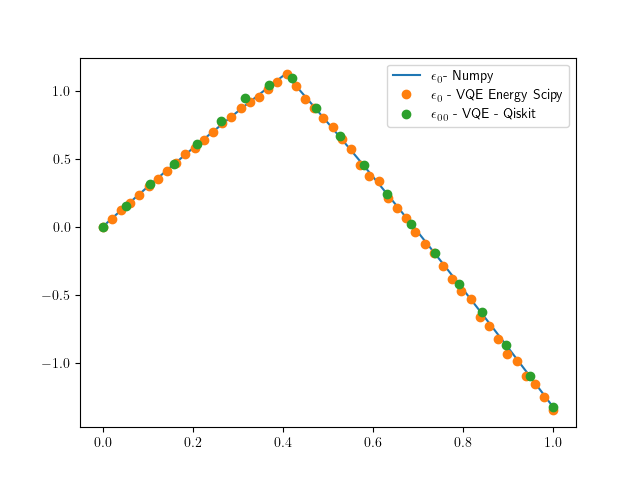

In [58]:
plt.figure()
plt.plot(lmbdas, Eigenvalue[0,:], label=r'$\epsilon_{0}$- Numpy')
plt.plot(lmbvalues, min_energy_scipy, label=r'$\epsilon_{0}$ - VQE Energy Scipy', marker='o', linestyle="")
plt.plot(np.linspace(0,1,20), minimum_eigenvalues_2q,  linestyle="",marker="o",label=r'$\epsilon_{00}$ - VQE - Qiskit')
plt.legend()


## Part F

In [85]:
# Hamiltonian for 2 particles J = 1, Jz = {-1, 0, 1}
# Hamiltonian for 4 particles J = 2, Jz = {-2, -1, 0, 1, 2}
#function that sorts eigenvalues with its eigenvectors in accending order
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

def Hamiltonian_Lipkin(N=2, epsilon=1.0, V=1.0, W=1.0, print_H=False):
    # Define symbolic parameters for pretty printing
    eps_sym, V_sym, W_sym = sp.symbols('epsilon V W')
    
    # Define the Hamiltonian symbolically (write it only once)
    if N == 2:
        H_sym = sp.Matrix([
            [-eps_sym,   0, -V_sym],
            [       0, W_sym,    0],
            [   -V_sym,  0,  eps_sym]
        ])
    elif N == 4:
        H_sym = sp.Matrix([
            [-2*eps_sym,         0, sp.sqrt(6)*V_sym,         0,           0],
            [         0, -eps_sym+3*W_sym,         0,      3*V_sym,           0],
            [ sp.sqrt(6)*V_sym,         0,         0,         0, sp.sqrt(6)*V_sym],
            [         0,      3*V_sym,         0, eps_sym+3*W_sym,         0],
            [         0,         0, sp.sqrt(6)*V_sym,         0,   2*eps_sym]
        ])
    else:
        print("N must be 2 or 4")
        return None

    # Pretty print the symbolic Hamiltonian if requested
    if print_H:
        sp.pprint(H_sym)
    
    # Substitute the numeric values into the symbolic Hamiltonian and convert to a NumPy array
    H_numeric = np.array(H_sym.subs({eps_sym: epsilon, V_sym: V, W_sym: W}), dtype=float)
    return H_numeric

This is the Hamiltonian we obtain for a 2 particle system

In [86]:
H_Lipkin_2p = Hamiltonian_Lipkin(N=2, print_H=True)

⎡-ε  0  -V⎤
⎢         ⎥
⎢0   W  0 ⎥
⎢         ⎥
⎣-V  0  ε ⎦


We can compute its eigenvalues using Numpy library LInalg

In [ ]:
# Let's consider the case for W = 0
n = 20
Eigenvalue_2p_W0 = np.zeros((3,n))
Eigvector_2p_W0 = [np.zeros((3,3)).copy() for _ in range(n)]

for i, V in enumerate(np.linspace(0,2,n)):
    H_2p = Hamiltonian_Lipkin(N=2, epsilon=1, V=V, W=0, print_H=False)
    eigenValues, eigenVectors = eigen(H_2p)
    Eigenvalue_2p_W0[0,i] = eigenValues[0]
    Eigenvalue_2p_W0[1,i] = eigenValues[1]
    Eigenvalue_2p_W0[2,i] = eigenValues[2]
    Eigvector_2p_W0[i][:,0] = eigenVectors[0]
    Eigvector_2p_W0[i][:,1] = eigenVectors[1]
    Eigvector_2p_W0[i][:,2] = eigenVectors[2]


When $W = 0,$ we can reduce the two particle system to a one qubit system and the resulting matrix is
$$
H^{N=2} = \begin{bmatrix}
-\epsilon/2 & -V \\
-V & \epsilon/2
\end{bmatrix} = -\frac{\epsilon}{2} Z  - V X,
$$


Alternatively, we can rewrite the Hamiltonian as function of Pauli's matrices and as a two qubit system as follows
$$
H^{N=2} = \frac{\epsilon}{2}\left(Z_1 + Z_2\right) + \frac{W-V}{2} X_1 X_2 - \frac{W+V}{2} Y_1 Y_2,
$$


In [103]:
# For W = 0, the 2 particles system can be approximated with a 1 qubit system. Hamiltonian expressed as Pauly matrices

# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=200)
epsilon=1
minimum_eigenvalues_1p_W0 = []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_1p_W0 = SparsePauliOp.from_list(
        [("Z", -epsilon), ("X", -V)]
    )
    ansatz = TwoLocal(num_qubits=1, rotation_blocks=["rx","ry"])
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_1p_W0)
    minimum_eigenvalues_1p_W0 +=[result.eigenvalue.real]


/tmp/ipykernel_160567/1381072742.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


In [104]:
W = 0
n = 20

# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
epsilon=1
minimum_eigenvalues_2p_W0 = []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_2p_W0 = SparsePauliOp.from_list(
        [("ZI", epsilon/2), ("IZ", epsilon/2), ("XX", (-V+W)/2), ("YY", (W+V)/2)]
    )
    ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cx", reps=1)
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_2p_W0)
    print(result.eigenvalue.real)
    minimum_eigenvalues_2p_W0 +=[result.eigenvalue.real]

/tmp/ipykernel_160567/2784303894.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
  5%|▌         | 1/20 [00:02<00:50,  2.68s/it]

-1.000143584969819


 10%|█         | 2/20 [00:05<00:47,  2.67s/it]

-1.0053131765208343


 15%|█▌        | 3/20 [00:07<00:39,  2.33s/it]

-1.02081412171245


 20%|██        | 4/20 [00:09<00:34,  2.15s/it]

-1.0446684848662664


 25%|██▌       | 5/20 [00:10<00:30,  2.01s/it]

-1.0832076237477704


 30%|███       | 6/20 [00:12<00:26,  1.89s/it]

-1.1303966637249083


 35%|███▌      | 7/20 [00:14<00:25,  1.94s/it]

-1.1824270561752928


 40%|████      | 8/20 [00:16<00:24,  2.03s/it]

-1.2413172066874438


 45%|████▌     | 9/20 [00:19<00:25,  2.28s/it]

-1.3094984385335677


 50%|█████     | 10/20 [00:21<00:21,  2.18s/it]

-1.378216637292989


 55%|█████▌    | 11/20 [00:23<00:18,  2.03s/it]

-1.451376917943906


 60%|██████    | 12/20 [00:24<00:15,  1.93s/it]

-1.530104974417992


 65%|██████▌   | 13/20 [00:26<00:12,  1.83s/it]

-1.6055293736957037


 70%|███████   | 14/20 [00:28<00:11,  1.85s/it]

-1.6928614436704255


 75%|███████▌  | 15/20 [00:30<00:09,  1.82s/it]

-1.7814406923719874


 80%|████████  | 16/20 [00:32<00:07,  1.96s/it]

-1.8683687636648714


 85%|████████▌ | 17/20 [00:34<00:06,  2.03s/it]

-1.9582044136458503


 90%|█████████ | 18/20 [00:36<00:04,  2.07s/it]

-2.047231902849543


 95%|█████████▌| 19/20 [00:38<00:02,  2.02s/it]

-2.1403812315472006


100%|██████████| 20/20 [00:40<00:00,  2.04s/it]

-2.230035731833653


We can also write utilize a stochastic approach to measure the lowest eigenvalue of the system.

In [ ]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, v, w, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_sdag(0)
    qubit.apply_hadamard(0)
    qubit.apply_sdag(1)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_yy = qubit.measure(number_shots)
    

    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
    constants = np.array([1/2, 1/2, -v/2+w/2, v/2+w/2])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [106]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
w=0
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


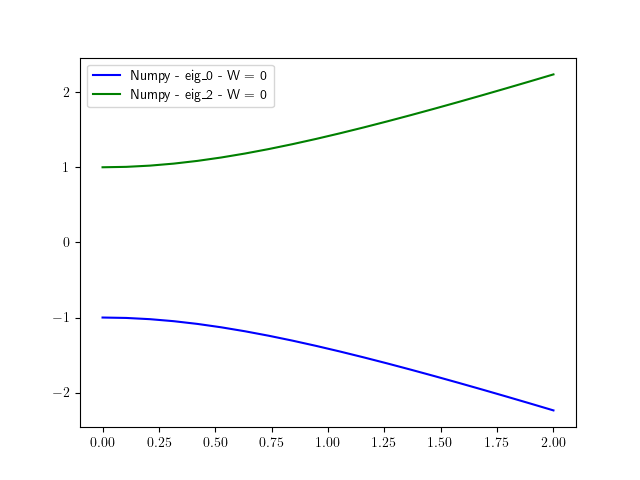

In [107]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_W0[0,:], linestyle="-", color="blue", label="Numpy - eig_0 - W = 0")
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_W0[2,:], linestyle="-", color="green", label="Numpy - eig_2 - W = 0")
plt.legend()

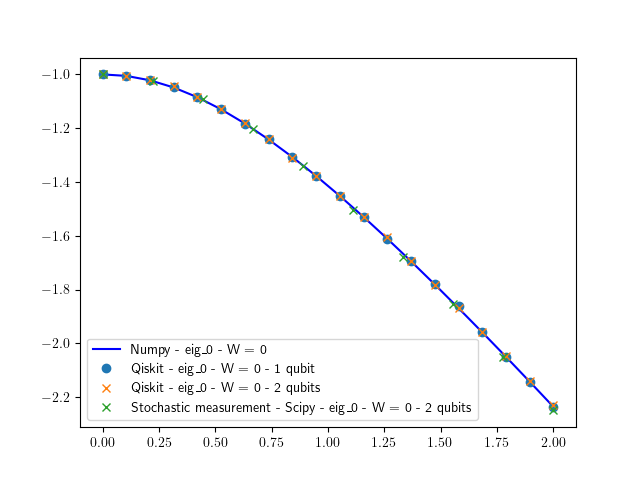

In [108]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_W0[0,:], linestyle="-", color="blue", label="Numpy - eig_0 - W = 0")

plt.plot(np.linspace(0,2,n), minimum_eigenvalues_1p_W0, marker="o", linestyle="", label="Qiskit - eig_0 - W = 0 - 1 qubit")
plt.plot(np.linspace(0,2,n), minimum_eigenvalues_2p_W0, marker="x", linestyle="", label="Qiskit - eig_0 - W = 0 - 2 qubits")
plt.plot(v_vals, min_energy_scipy, marker="x", linestyle="", label="Stochastic measurement - Scipy - eig_0 - W = 0 - 2 qubits")

plt.legend()


We can consider the case $W=-1.5$

In [110]:
# Let's consider the case for W = -1.5
n = 20
Eigenvalue_2p_Wminus1_5 = np.zeros((3,n))
Eigvector_2p_Wminus1_5 = [np.zeros((3,3)).copy() for _ in range(n)]
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

for i, V in enumerate(np.linspace(0,2,n)):
    H_2p = Hamiltonian_Lipkin(N=2, epsilon=1, V=V, W=-1.5, print_H=False)
    eigenValues, eigenVectors = eigen(H_2p)
    Eigenvalue_2p_Wminus1_5[0,i] = eigenValues[0]
    Eigenvalue_2p_Wminus1_5[1,i] = eigenValues[1]
    Eigenvalue_2p_Wminus1_5[2,i] = eigenValues[2]
    Eigvector_2p_Wminus1_5[i][:,0] = eigenVectors[0]
    Eigvector_2p_Wminus1_5[i][:,1] = eigenVectors[1]
    Eigvector_2p_Wminus1_5[i][:,2] = eigenVectors[2]

In [114]:
W = -1.5
n = 20

# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
epsilon=1
minimum_eigenvalues_2p_Wminus1_5= []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_2p_Wminus1_5 = SparsePauliOp.from_list(
        [("ZI", epsilon/2), ("IZ", epsilon/2), ("XX", (-V+W)/2), ("YY", (W+V)/2)]
    )
    ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cx", reps=1)
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_2p_Wminus1_5)
    print(result.eigenvalue.real)
    minimum_eigenvalues_2p_Wminus1_5 +=[result.eigenvalue.real]

/tmp/ipykernel_160567/3034462254.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
  5%|▌         | 1/20 [00:02<00:52,  2.76s/it]

-1.4552491882808238


 10%|█         | 2/20 [00:05<00:45,  2.51s/it]

-1.4983710966487156


 15%|█▌        | 3/20 [00:07<00:41,  2.43s/it]

-1.4979205278577692


 20%|██        | 4/20 [00:09<00:36,  2.31s/it]

-1.4959804305110656


 25%|██▌       | 5/20 [00:11<00:34,  2.33s/it]

-1.4996586842541642


 30%|███       | 6/20 [00:13<00:31,  2.23s/it]

-1.4999099935363123


 35%|███▌      | 7/20 [00:18<00:37,  2.85s/it]

-1.4989115155043655


 40%|████      | 8/20 [00:21<00:34,  2.89s/it]

-1.478175870458324


 45%|████▌     | 9/20 [00:23<00:30,  2.75s/it]

-1.4994786366962376


 50%|█████     | 10/20 [00:26<00:27,  2.70s/it]

-1.488753986159761


 55%|█████▌    | 11/20 [00:28<00:22,  2.52s/it]

-1.4561710189663013


 60%|██████    | 12/20 [00:30<00:20,  2.59s/it]

-1.50269945181904


 65%|██████▌   | 13/20 [00:33<00:17,  2.54s/it]

-1.5533248436080935


 70%|███████   | 14/20 [00:35<00:14,  2.45s/it]

-1.515835660330162


 75%|███████▌  | 15/20 [00:37<00:11,  2.38s/it]

-1.4996142828973202


 80%|████████  | 16/20 [00:41<00:11,  2.81s/it]

-1.848735043349666


 85%|████████▌ | 17/20 [00:45<00:08,  2.98s/it]

-1.9448963293450516


 90%|█████████ | 18/20 [00:49<00:06,  3.42s/it]

-2.049875454293251


 95%|█████████▌| 19/20 [00:52<00:03,  3.40s/it]

-2.025206332549836


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

-2.195284915207517


In [115]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
w=-1.5
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


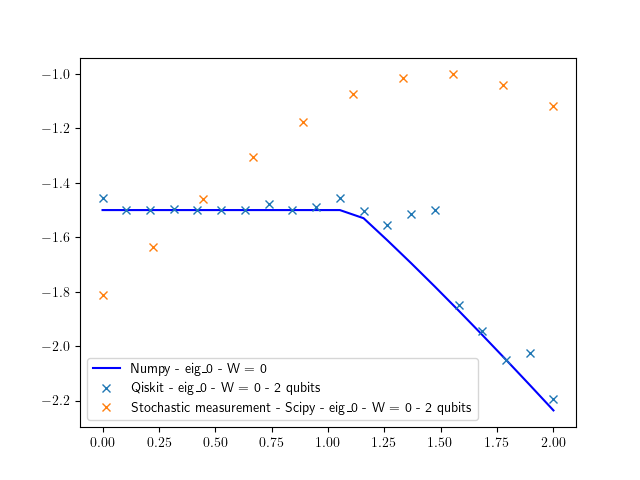

In [116]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_Wminus1_5[0,:], linestyle="-", color="blue", label="Numpy - eig_0 - W = 0")

plt.plot(np.linspace(0,2,n), minimum_eigenvalues_2p_Wminus1_5, marker="x", linestyle="", label="Qiskit - eig_0 - W = 0 - 2 qubits")
plt.plot(v_vals, min_energy_scipy, marker="x", linestyle="", label="Stochastic measurement - Scipy - eig_0 - W = 0 - 2 qubits")

plt.legend()

In [ ]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
w=-1.5
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

In [31]:
H_Lipkin_4p = Hamiltonian_Lipkin(N=4, print_H=True)

⎡-2⋅ε     0     √6⋅V     0      0  ⎤
⎢                                  ⎥
⎢ 0    3⋅W - ε   0      3⋅V     0  ⎥
⎢                                  ⎥
⎢√6⋅V     0      0       0     √6⋅V⎥
⎢                                  ⎥
⎢ 0      3⋅V     0    3⋅W + ε   0  ⎥
⎢                                  ⎥
⎣ 0       0     √6⋅V     0     2⋅ε ⎦


In [32]:
import cmath
from scipy.sparse import diags
import pandas as pd

#function that sorts eigenvalues with its eigenvectors in accending order
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

#one body expectation value
def one_body(E,N):
  k = N/2
  m = np.arange(-k,k+1,1) # Since the collective space is Omega+1
  return E*np.diag(m) #return a matrix where its diagonal elemens are epsilon*K_0

#two body expectation value
def two_body(V,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  left =np.zeros(len(m)-2,dtype=np.complex128)
  right = np.zeros(len(m)-2,dtype=np.complex128)
  diag = np.zeros(len(m),dtype=np.complex128)
  for i in range(len(left)):
    CG = cmath.sqrt(k*(k+1)-(m[i]+2)*(m[i]+1))*cmath.sqrt(k*(k+1)-m[i]*(m[i]+1)) #calculate Clebsch-Gordan Coefficients 
    left[i] = CG
    right[i] = CG
  k = [left,diag,right]
  offset = [-2,0,2]
  return -0.5*V*diags(k,offset).toarray() #return a matrix where its off digonal elements are (1/2)V(K^2_+ + K^2_-)

#full expectation value
def quasi_spin(E,V,N):
  ob = one_body(E,N)
  tb = two_body(V,N)
  H = ob+tb 
  e,v = eigen(H) # find the eigenvalues of the Hamiltonian
  return e,H

#converts chi to V
def Vp(E,omega,chi):
  return (chi*E)/(omega-1)


In [33]:
#parameters
E = 1
chi = np.arange(0,2.1,0.1)
omega = 2

EV0 = []
EV1 = []
EV2 = []
Ham = []
for i in chi:
  v = Vp(E,omega,i)
  EigenV,H = quasi_spin(E,v,omega) #return eigenvalues and Hamiltonian
  print(H)
  Ham.append(H)
  EV0.append(EigenV[0])
  EV1.append(EigenV[1])
  EV2.append(EigenV[2])

[[-1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j]]
[[-1. +0.j  0. +0.j -0.1+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.1+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.2+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.2+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.3+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.3+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.4+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.4+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.6+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.6+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.7+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.7+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.8+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.8+0.j  0. +0.j  1. +0.j]]
[[-1. +0.j  0. +0.j -0.9+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [-0.9+0.j  0. +0.j  1. +0.j]]
[[-1.+0.j  0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [-1.+0.j  0.+0.j  1.+0.j]]
[[-1. +0.j  0. +0

Hamiltonian matrix


/home/eleonora/Projects/FYS5419-Piersanti/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/eleonora/Projects/FYS5419-Piersanti/venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, '$\\Omega=2$ exact Lipkin Model')

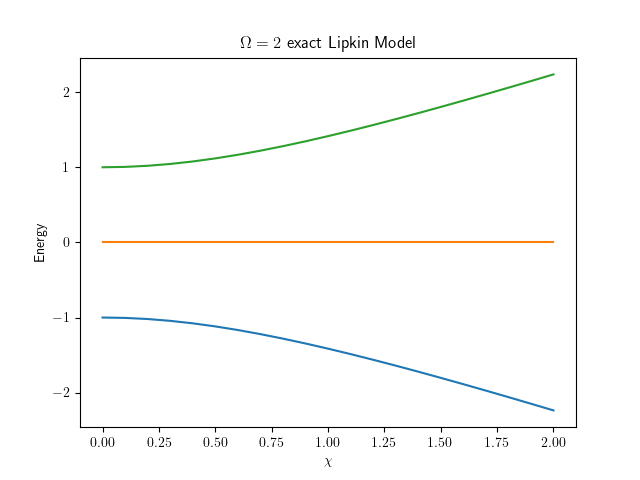

In [34]:
matrix = pd.DataFrame(Ham[5].real)
print('Hamiltonian matrix')
matrix.head()

plt.figure()
plt.plot(chi,EV0)
plt.plot(chi,EV1)
plt.plot(chi,EV2)
plt.xlabel('$\chi$')
plt.ylabel('Energy')
plt.title('$\Omega=2$ exact Lipkin Model')